In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
lambda = 0.01 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed using setthreshold!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
L = 50 # batchsize 
# set low for training but high for classification
activation = Flux.relu
layer = Flux.Dense
rdelta = 1e-3 # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, M=M, activation = activation, layer = layer, rdelta = rdelta, Beta = Beta, 
    tracked = tracked)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 2))), 0.01, 0, 0.1262135922330097, 2000, 500, true, 50, 1, 0.001f0, 1.0f0, MVHistory{ValueHistories.History}, "rerr")

In [4]:
# fit the model
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.fit!(model, nX)
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.setthreshold!(model, X)

loss: 0.514533
reconstruction error: 0.5007871
KL: 0.34039575

loss: 0.057676878
reconstruction error: 0.04394935
KL: 1.4144621

loss: 0.029643498
reconstruction error: 0.010690349
KL: 1.9195344

loss: 0.020452034
reconstruction error: 0.0073962454
KL: 1.5047284

loss: 0.017311178
reconstruction error: 0.0048900656
KL: 1.4255612

loss: 0.017176393
reconstruction error: 0.0043839244
KL: 1.4190171



0.021381143f0

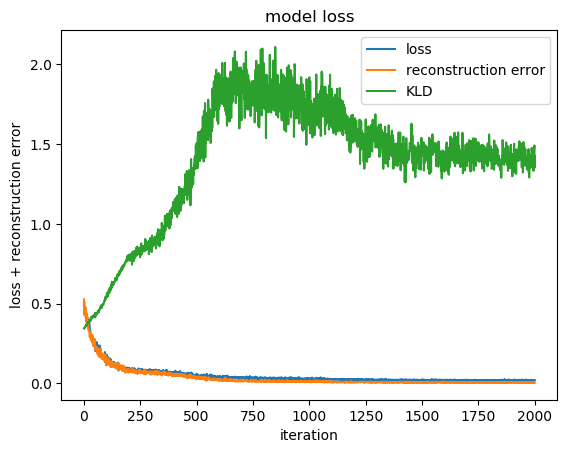

In [5]:
plot(model)
show()

How does the model reconstruct the normal data?

In [6]:
model(nX)

Tracked 2×90 Array{Float32,2}:
 0.759202  0.672606  0.762603  0.88757   …  0.0501414  0.222964  0.0332109
 0.777551  0.683841  0.757517  0.917894     0.989348   0.863517  0.982877 

In [7]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

What are the parameters of $q(z|x)$?

In [8]:
AnomalyDetection.muz(model, nX)

Tracked 2×90 Array{Float32,2}:
 -0.00685917  -0.00683318  -0.00647239  …  0.0150047  0.0146362  0.0145891
 -1.16926     -1.16904     -1.17769        0.989781   0.977295   0.9757   

In [9]:
AnomalyDetection.sigmaz(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.97923   0.979274  0.979646  0.980964  …  0.997574  0.99591   0.995697
 0.161535  0.161535  0.160757  0.158373     0.400247  0.400596  0.400641

What do the generated samples look like?

In [10]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
 -0.375278   1.58956   1.28495   0.170992  …  -0.802415  -0.227606  -0.875762
 -1.31455   -1.20586  -1.25765  -1.33134       0.772364   0.774401   1.05148 

In [11]:
# predict labels on testing data
model.M = 100 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 1
 1
 1
 0
 1
 1
 1
 1

In [12]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 90
  fp = 0
  fn = 2
precision: 1.0
f1score: 0.9166666666666666
recall: 0.8461538461538461
false positive rate: 0.0
equal error rate: 0.07692307692307693

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 90
  fp = 0
  fn = 2
precision: 1.0
f1score: 0.9166666666666666
recall: 0.8461538461538461
false positive rate: 0.0
equal error rate: 0.07692307692307693


In [13]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

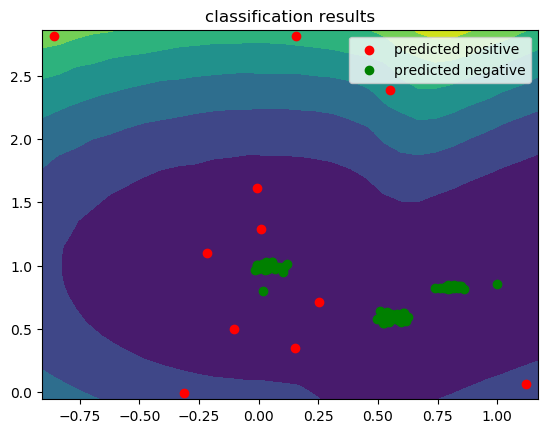

In [14]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

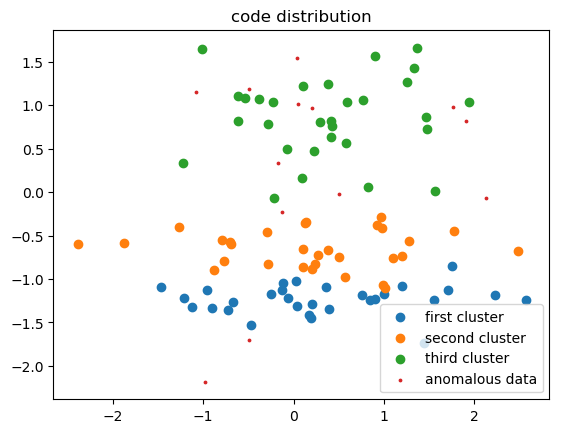

In [15]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

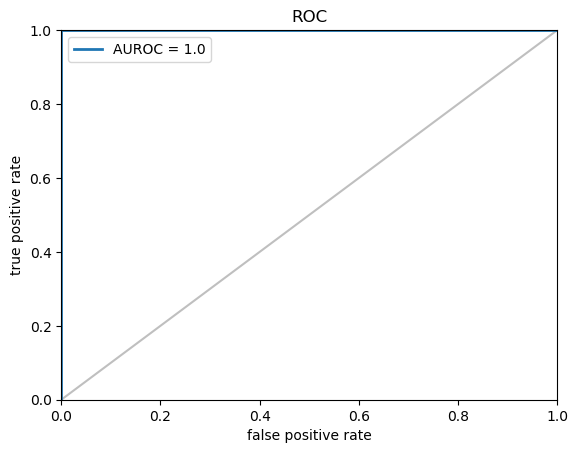

In [16]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()